In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

import cv2
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls

data_dir = 'D:/Downloads/amazon/'

print('# File sizes')
for f in os.listdir(data_dir):
    if not os.path.isdir(data_dir + f):
        print(f.ljust(30) + str(round(os.path.getsize(data_dir + f) / 1000000, 2)) + 'MB')
    else:
        sizes = [os.path.getsize(data_dir+f+'/'+x)/1000000 for x in os.listdir(data_dir + f)]
        print(f.ljust(30) + str(round(sum(sizes), 2)) + 'MB' + ' ({} files)'.format(len(sizes)))

# File sizes
sample_submission.csv         1.0MB (2 files)
test-jpg                      0.0MB (40669 files)
test-tif.tar.7z               13298.0MB
train-jpg                     0.0MB (40479 files)
train-jpg-sample              0.0MB (100 files)
train-tif-sample              0.0MB (100 files)
train-tif.tar                 21848.0MB
train-tif.tar.7z              13233.0MB
train.csv                     1.0MB
__MACOSX                      0.0MB (1 files)


In [4]:
df_train = pd.read_csv(data_dir + 'train.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


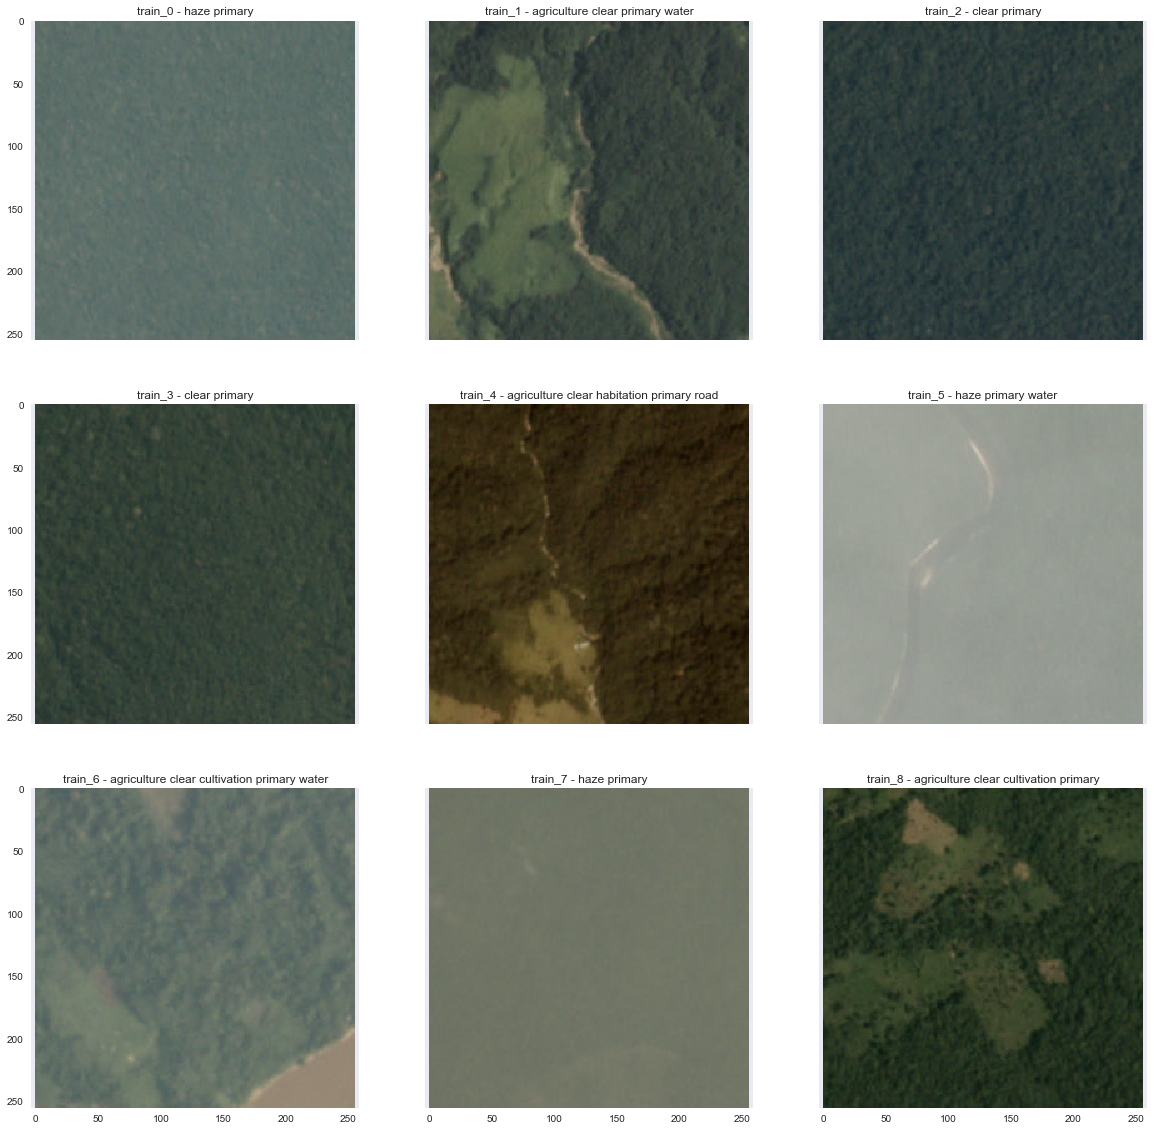

In [6]:


new_style = {'grid': False}
plt.rc('axes', **new_style)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(20, 20))
i = 0
for f, l in df_train[:9].values:
    img = cv2.imread(data_dir + 'train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    #ax[i // 4, i % 4].show()
    i += 1
    
plt.show()